# Krylov subspace expansion with Qiskit

## High level view of quantum Krylov subspace algorithm

Given a matrix H that we are interested in, subspace methods use a set of states as a basis for the construction of a smaller representation of H, which captures its properties of interest (e.g. lowest eigenvalue).



What is the Krylov subspace? 

$$K^r = \left\{ \vert \psi \rangle, H \vert \psi \rangle, H^2 \vert \psi \rangle, ..., H^{r-1} \vert \psi \rangle \right\}$$

Is the krylov subspace for a given matrix $H$ and vector $\vert \psi \rangle$ of order $r$ where $\vert \psi \rangle$ is an aribitrary state called "reference state".

The reference state can be expanded in terms of the eigenvectors $\vert lambda_i \rangle$ of the matrix $H$:

$$ \vert \psi \rangle = c_1 \vert \lambda_1 \rangle + c_2 \vert \lambda_2 \rangle + ... + c_n \vert \lambda_n \rangle $$

Applying $j^{th}$ power of the matrix $H$ gives:

$$ H^n \vert \psi \rangle = c_1 \lambda_1^n \vert \lambda_1 \rangle + c_2 \lambda_2^n \vert \lambda_2 \rangle + ... + c_n \lambda_n^n \vert \lambda_n \rangle $$

Which means that the component $k$ with the largest eigenvalue $\lambda_k$ is amplified by the power iteration (This can also be a problem as the basis vector become too similar to each other). The same is true for the smallest eigenvalue, if we consider power iteration of the matrix $A^{-1}$.

Why is it useful for ground state energy problems?

The Krylov subspace is constructed using the power iteration method. Therefore, states in the Krylov subspace corresponding to the multiplication with higher power of the matrix with the reference states will have the contribution of the ground state $\vert \lambda_k \rangle$ enhanced.

The Krylov subspace that we use classically cannot be accessed on a quantum computer as $H$ is not a unitary matrix. Instead, we can use the time-evolution operator $U = e^{-iHt}\sim \sum_j \frac{(-it)^j}{j!}H^j$ which is equivalent for small times $t$. Powers of $U$ then become different time steps $U^k = e^{-iH(kt)}$.


$$K_U^r = \left\{ \vert \psi \rangle, U \vert \psi \rangle, U^2 \vert \psi \rangle, ..., U^{r-1} \vert \psi \rangle \right\}$$






### Imoprts and definitions

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pylab as plt
import warnings
warnings.filterwarnings('ignore')

from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import SuzukiTrotter, MatrixExponential


def solve_regularized_gen_eig(h, s, threshold, k=1, return_dimn=False):
    s_vals, s_vecs = sp.linalg.eigh(s)
    s_vecs = s_vecs.T
    good_vecs = np.array([vec for val, vec in zip(s_vals, s_vecs) if val > threshold])
    h_reg = good_vecs.conj() @ h @ good_vecs.T
    s_reg = good_vecs.conj() @ s @ good_vecs.T
    if k==1:
        if return_dimn:
            return sp.linalg.eigh(h_reg, s_reg)[0][0], len(good_vecs)
        else:
            return sp.linalg.eigh(h_reg, s_reg)[0][0]
    else:
        if return_dimn:
            return sp.linalg.eigh(h_reg, s_reg)[0][:k], len(good_vecs)
        else:
            return sp.linalg.eigh(h_reg, s_reg)[0][:k]
        

### Define Hamiltonian
Let's condider the kicked Ising Hamiltonian for $N$ qubits on a linear chain: $H=J \sum_{i,j}^N Z_i Z_j + h \sum_i^N X_i$

In [2]:
# Define problem Hamiltonian. Kicked Ising in this case
n_qubits = 4
J = 1 # coupling strength for ZZ interaction
h = 3 # strength of "magnetic" X term

# Define non-interacting part of the Hamiltonian: \sum_i X_i
H_nonint = [['I']*n_qubits for _ in range(n_qubits)]
for i in range(n_qubits):
    H_nonint[i][i] = 'X'
H_nonint = [''.join(term) for term in H_nonint]

# Define interacting part of the Hamiltonian: sum_ij Z_i Z_j
H_int = [['I']*n_qubits for _ in range(n_qubits-1)]
for i in range(n_qubits-1):
    H_int[i][i] = 'Z'
    H_int[i][i+1] = 'Z'
H_int = [''.join(term) for term in H_int]
H_tot = [(term, -J) for term in H_int] + [(term, h) for term in H_nonint]

# Get operator
H_op = SparsePauliOp.from_list(H_tot)
H_op

SparsePauliOp(['ZZII', 'IZZI', 'IIZZ', 'XIII', 'IXII', 'IIXI', 'IIIX'],
              coeffs=[-1.+0.j, -1.+0.j, -1.+0.j,  3.+0.j,  3.+0.j,  3.+0.j,  3.+0.j])

### Get ground state exactly
We can diagonalize the Hamiltonian and get the ground state and its energy directly. However, this becomes prohibitive rather quickly as the size of the matrix grow exponentially with $N$. The diagonalization algorithm also takes $O(M^3)$ operations where $M=2^N$ is the size of the matrix.

In [3]:
# get ground state energy and state
eig_vals, eig_vecs = np.linalg.eigh(H_op.to_matrix())
gnd_idx  = np.argmin(eig_vals)
gnd_en = eig_vals[gnd_idx]
gnd_state = eig_vecs[gnd_idx]

print('The exact ground state energy is:', gnd_en)


The exact ground state energy is: -12.250560622684286


### Use ideal quantum Krylov algorithm
For sparse, Hermitean matrices we can use the Lanczos algorithm or its unitary version (shown below).


Here we go through the entire workflow to find an estimate of the ground state using the unitary Krylov subspace expansion. First, we want to find a compact represention of the Hamiltonian in the Krylov subspace $\tilde{H}$. Given that the Krylov subspace has dimension $r$, the Hamiltonian projected into the Krylov subspace will have dimensions $r \times r$. We can then easily diagonalize the projected Hamiltonian $\tilde{H}$. However, we cannot directly diagonalize $\tilde{H}$ because of the non-orthogonality of the Krylov subpace vectors. We'll have to measure theyr overlaps and construct a matrix $\tilde{S}$ collecting them to do so. We can then  solve the generalized eigenvalue problem

$$ \tilde{H} \ c = E \ \tilde{S} \ c $$

Where $\tilde{H}=\langle \psi_m \vert \hat{H} \vert \psi_n \rangle$ is the Hamiltonian matrix in the Krylov subspace $K_D = \left\{ \vert \psi_0 \rangle, \vert \psi_1 \rangle, ..., \vert \psi_D \rangle \right\}$ with dimension $D$, $c$ is a vector of variational coefficients that are optimized to get the lowest value of the energy $E$ and $\tilde{S}=\langle \psi_m  \vert \psi_n \rangle$ is a matrix of overlaps between states of the Krylov subspace.

Each of the Krylov subspace's vectors are obtained by time-evolving the reference state $\vert \psi_0 \rangle$ under the Hamiltonian $\hat{H}$ for a certain time: $\vert \psi_l \rangle = \hat{U} \vert \psi_0 \rangle = e^{-i \hat{H} t_l}\vert \psi_0 \rangle$. 

In [4]:
# Set parameters for quantum Krylov algorithm
krylov_dim = 6 # size of krylov subspace
dt = 0.1 # time step

Calculate the time evolution operator $U$

In [5]:
# Calculate time-evolution operator
time_evo_op = sp.linalg.expm(-1j*H_op*dt)

Pick a reference state $\vert \psi \rangle$. Below we use the transpiler and the knowledge of the exact ground state to generate a state that has some overlap with the ground state

In [6]:
from qiskit.quantum_info import Statevector
from qiskit import transpile
qc = QuantumCircuit(4)
qc.prepare_state(gnd_state)
qc_state_prep = transpile(qc, basis_gates=['cx', 'rz', 'sx'], optimization_level = 3, approximation_degree = 0.6)

In [7]:
# Pick initial guess. It should have meaningful overlap with the ground state
initial_guess = Statevector(qc_state_prep).data.reshape(2**n_qubits,1)

Build the Krylov subspace $K_U^D = \left\{ \vert \psi_0 \rangle, \vert \psi_1 \rangle, ..., \vert \psi_D \rangle \right\} = \left\{ \vert \psi \rangle, U \vert \psi \rangle, ..., U^D \vert \psi \rangle \right\}$

In [8]:
# Build Krylov subspace
krylov_ops = [np.linalg.matrix_power(time_evo_op, k) for k in range(krylov_dim)]
krylov_subspace = [kr_ops @ initial_guess for kr_ops in krylov_ops]

For increasing Krylov subspace dimension (up to $D$), we calculate the projections of $H$ and the overlaps between the Krylov subspace vectors and calculate an estimate of the ground state energy. It can be seen that the estimate converges exponentially with the size of the Krylov subspace

In [9]:

# Convert Hamiltonian Op to matrix
H_mat = H_op.to_matrix()

# Get estimated ground state energy for different dimensions of the Krylov subspace
gnd_en_est_list = []
for d in range(1, krylov_dim+1):
    # Project Hamiltonian in Krylov subspave
    H_eff = np.zeros((d, d), dtype=complex)
    for i in range(d):
        for j in range(i+1):
            h = np.trace(krylov_subspace[i].T.conj() @ H_mat @ krylov_subspace[j])
            H_eff[i,j] = h
            H_eff[j,i] = h.conj()

    # Calculate overlap of Krylov subspave vectors
    S = np.zeros((d, d), dtype=complex)
    for i in range(d):
        for j in range(i+1):
            s =  np.trace(krylov_subspace[i].T.conj() @ krylov_subspace[j])
            S[i,j] = s
            S[j, i] = s.conj()

    # Solve generalized eigenvalue problem
    gnd_en_est = solve_regularized_gen_eig(H_eff, S, threshold=1e-13)
    gnd_en_est_list.append(gnd_en_est)
    print('The estimated ground state energy is: ', gnd_en_est)

The estimated ground state energy is:  -3.918589908971955
The estimated ground state energy is:  -6.610329157691495
The estimated ground state energy is:  -8.67995221211817
The estimated ground state energy is:  -11.060854196368584
The estimated ground state energy is:  -12.039402134639037
The estimated ground state energy is:  -12.21118609948701


In [10]:
from sympy import Matrix
Matrix(H_eff)

Matrix([
[-3.91858990897195 - 2.22044604925031e-16*I,      -2.96164378427887 - 2.8734834802044*I,     -0.772499747266053 - 4.1053350937096*I,      1.26638899883635 - 3.39328585004785*I,      2.28659693349833 - 1.69550205861274*I, 2.35748052782969 - 0.0325127788885871*I],
[     -2.96164378427887 + 2.8734834802044*I, -3.91858990897195 + 1.11022302462516e-16*I,      -2.96164378427887 - 2.8734834802044*I,     -0.772499747266053 - 4.1053350937096*I,      1.26638899883635 - 3.39328585004785*I,   2.28659693349833 - 1.69550205861274*I],
[    -0.772499747266053 + 4.1053350937096*I,      -2.96164378427887 + 2.8734834802044*I, -3.91858990897195 - 2.22044604925031e-16*I,      -2.96164378427887 - 2.8734834802044*I,     -0.772499747266053 - 4.1053350937096*I,   1.26638899883635 - 3.39328585004785*I],
[     1.26638899883635 + 3.39328585004785*I,     -0.772499747266053 + 4.1053350937096*I,      -2.96164378427887 + 2.8734834802044*I, -3.91858990897195 - 1.11022302462516e-16*I,      -2.96164378427887 - 

Text(0.5, 1.0, 'Estimating Ground state energy with Quantum Krylov')

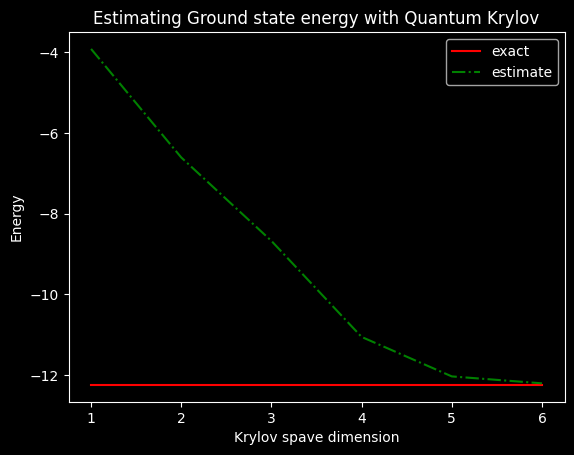

In [11]:
plt.plot(range(1, len(krylov_subspace)+1), [gnd_en]*(len(krylov_subspace)), color = 'red', label = 'exact')
plt.plot(range(1, len(krylov_subspace)+1), gnd_en_est_list, color = 'green', linestyle='-.' , label = 'estimate')
plt.xticks(range(1, len(krylov_subspace)+1), range(1, len(krylov_subspace)+1))
plt.legend()
plt.xlabel('Krylov spave dimension')
plt.ylabel('Energy')
plt.title('Estimating Ground state energy with Quantum Krylov')

## Quantum Krylov using qiskit
Implementing the unitary Krylov algorithm on a quantum computer overcomes the issues described above: 
- No memory limits: Hamiltonian operator and the quantum state can be represented in $O(N)$ memory

Each circuit implements a version of the Hadamard test to calculate the expectation value of the Paulis in the Hamiltonian for the states in the Krylov subspace:

$$\langle \psi_m \vert \hat{H} \vert \psi_n \rangle$$
$$\langle \psi_0 \vert  e^{i \hat{H} t_m}   \hat{H} e^{-i \hat{H} t_n} \vert \psi_0 \rangle$$
$$\langle \psi_0 \vert  e^{i \hat{H} m \delta t}   \hat{H} e^{-i \hat{H} n \delta t} \vert \psi_0 \rangle$$
$$\langle \psi_0 \vert \hat{H} e^{-i \hat{H} (n-m) \delta t} \vert \psi_0 \rangle$$

Given the symmetry properties of the dimer state, we can mesure all interaction terms of the Hamiltonian with two non-comuting sets of observables (below denoted as X and Z). The circuits for measuring X and Z are slightly different.

### State preparation
Once we have picked an initial guess $\vert \psi_0 \rangle$ we can construct a circuit that prepares it as $\vert \psi_0 \rangle = U_0 \vert 0 \rangle$

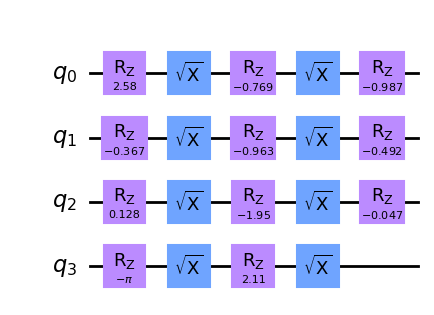

In [12]:
# Initial state preparation circuit
qc_state_prep.draw('mpl')

 We'll also need the circuit $U_0^{\dagger}$ that prepares the corresponding bra $\langle \psi_0 \vert = \langle 0 \vert U_0^{\dagger}$

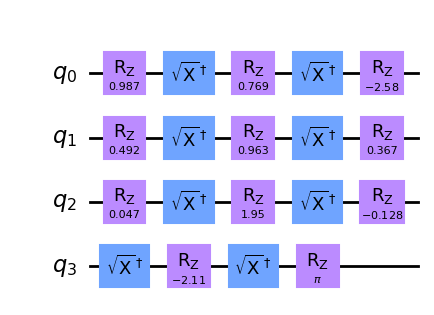

In [13]:
# Create the state prep dagger circuit
qc_state_prep_d = qc_state_prep.inverse()

qc_state_prep_d.draw('mpl')

### Time evolution

We can realize the time-evolution operator generated by a given Hamiltonian: $U=e^{-iHt}$

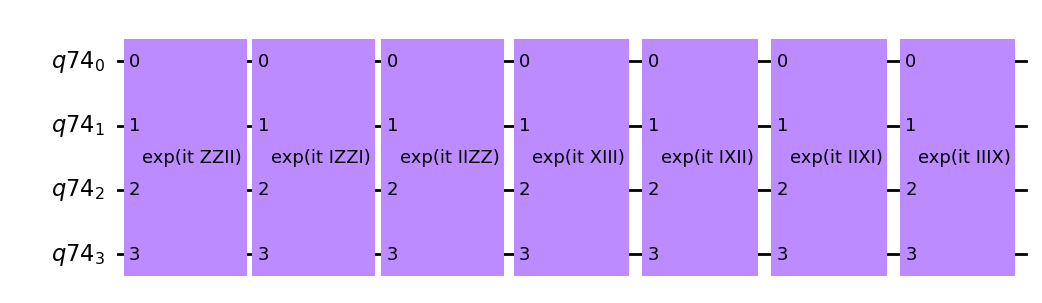

In [14]:
from qiskit.circuit import  Parameter

t = Parameter('t')
evol_gate = PauliEvolutionGate(H_op, time=t, synthesis=SuzukiTrotter(order=1)) #MatrixExponential exact matrix exp, SuzukiTrotter(order=2) for order-2 Trotter evo op

qreg = QuantumRegister(4)
evol_circ = QuantumCircuit(qreg)
evol_circ.append(evol_gate, qargs = qreg)
evol_circ.decompose().draw('mpl')

And we'll need the time-evolution operator $U^{\dagger}$ acting on the bra 

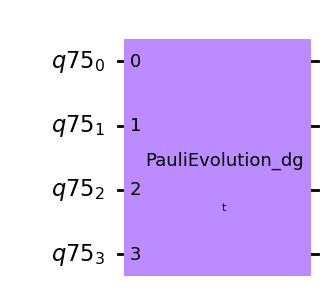

In [15]:
evol_gate = PauliEvolutionGate(H_op, time=t, synthesis=MatrixExponential()) #MatrixExponential exact matrix exp, SuzukiTrotter(order=2) for order-2 Trotter evo op
evol_gate_d = evol_gate.inverse()

qreg = QuantumRegister(4)
evol_d_circ = QuantumCircuit(qreg)
evol_d_circ.append(evol_gate_d, qargs = qreg)
evol_d_circ.draw('mpl')


The Hadamard test uses one ancillary qubit to control the operations in the expectation value. The unitary that is controlled will be the 

$$\langle \psi_0 \vert  e^{i \hat{H} t_m}   e^{-i \hat{H} t_n} \vert \psi_0 \rangle = \langle 0 \vert U_{tot} \vert 0 \rangle$$

where $U_{tot}^{(m,n)} = U_0^{\dagger} e^{i \hat{H} t_m} e^{-i \hat{H} t_n} U_0$. Let's first create a circuit for $U_{tot}^{(1,1)}$


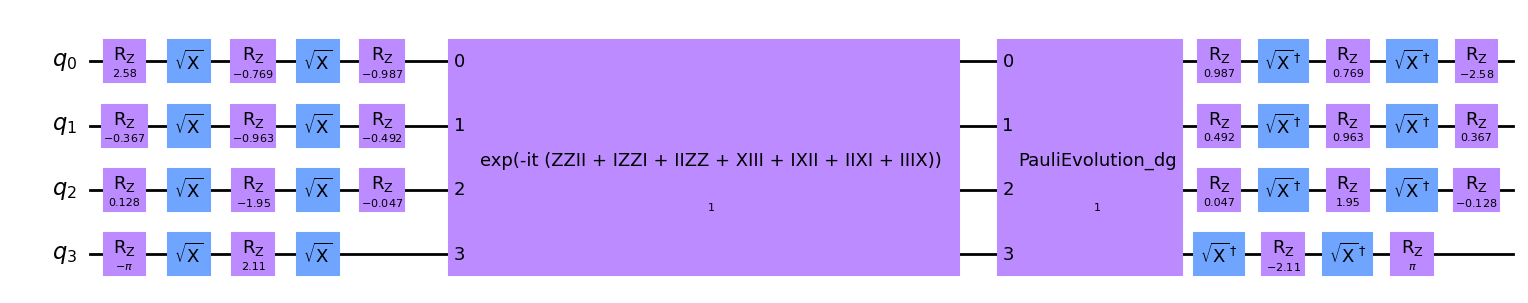

In [16]:

# Create the time-evo op instruction
evol_gate = PauliEvolutionGate(H_op, time=1, synthesis=SuzukiTrotter(order=2)) #MatrixExponential exact matrix exp, SuzukiTrotter(order=2) for order-2 Trotter evo op

## Create the time-evo op dagger instruction
evol_gate_d = PauliEvolutionGate(H_op, time=1, synthesis=SuzukiTrotter(order=2))
evol_gate_d = evol_gate_d.inverse()

# Put pieces together
qc_temp = QuantumCircuit(n_qubits, name='U_tot')
qc_temp.compose(qc_state_prep, inplace=True)
qc_temp.append(evol_gate, qargs=qc_temp.data[0].qubits[0].register)
qc_temp.append(evol_gate_d, qargs=qc_temp.data[0].qubits[0].register)
qc_temp.compose(qc_state_prep_d, inplace=True)

qc_temp.draw('mpl')

We can now add a qubit to act as the control qubit in the Hadamard test circuit

Real part of the overlap, calculatd with the Hadamard test


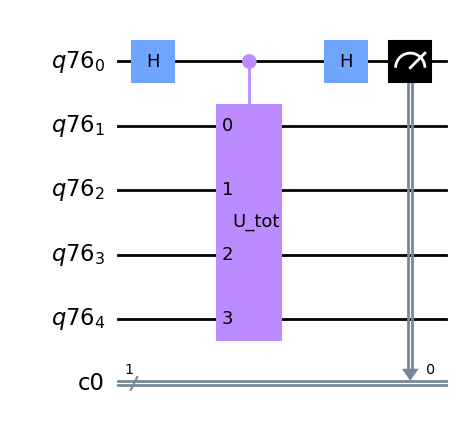

In [17]:

# Create controlled version of the circuit
controlled_U = qc_temp.to_gate().control(1)

# Create controlled version of the circuit
overlap_gate = qc_temp.to_gate()


# Create hadamard test circuit for real part
qr = QuantumRegister(n_qubits+1)
cr = ClassicalRegister(1)
qc_real = QuantumCircuit(qr, cr)
qc_real.h(0)
qc_real.append(controlled_U, list(range(n_qubits+1)))
qc_real.h(0)
qc_real.measure(qr[0], cr[0])

# Create hadamard test circuit for imaginary part
qr = QuantumRegister(n_qubits+1)
cr = ClassicalRegister(1)
qc_imag = QuantumCircuit(qr, cr)
qc_imag.h(0)
qc_imag.sdg(0)
qc_imag.append(controlled_U, list(range(n_qubits+1)))
qc_imag.h(0)
qc_imag.measure(qr[0], cr[0])

print('Real part of the overlap, calculated with the Hadamard test')
qc_real.draw('mpl')

The Hadamard test circuit can be a deep circuit once we transpile to native gates and topology of a device. For example the 5 qubits case considered here 

The circuit has 2Q gates depth:  336


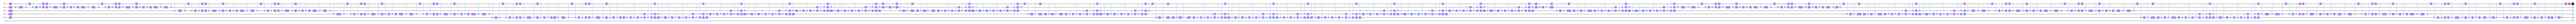

In [18]:
print('The circuit has 2Q gates depth: ', qc_real.decompose().decompose().depth(lambda x: x[0].num_qubits ==2))
qc_real.decompose().decompose().draw('mpl', fold=-1, scale = 0.5)

#### Calculate $\tilde{S}$ with Hadamard test
The $\tilde{S}$ matrix collects the overlaps between all vectors in the Krylov subspace, each matrix element can be calculated using the Hadamard test to get the overlap between different Krylov vectors:

$$ \tilde{S}_{ij} = \langle \psi_i \vert \psi_j \rangle$$

First, let's create all the circuits needed

In [19]:
S_real_circuits, S_imag_circuits = [], []
for idx_ket in range(krylov_dim):
    for idx_bra in range(idx_ket + 1):
        
        ## Create the time-evo op circuit
        evol_gate = PauliEvolutionGate(H_op, time=dt*idx_ket, synthesis=SuzukiTrotter(order=2) ) #MatrixExponential exact matrix exp, SuzukiTrotter(order=2) for order-2 Trotter evo op

        ## Create the time-evo op dagger circuit
        evol_gate_d = PauliEvolutionGate(H_op, time=dt*idx_bra, synthesis=SuzukiTrotter(order=2) )
        evol_gate_d = evol_gate_d.inverse()

        # Put pieces together
        qc_temp = QuantumCircuit(n_qubits)
        qc_temp.compose(qc_state_prep, inplace=True)
        qc_temp.append(evol_gate, qargs=qc_temp.data[0].qubits[0].register)
        qc_temp.append(evol_gate_d, qargs=qc_temp.data[0].qubits[0].register)
        qc_temp.compose(qc_state_prep_d, inplace=True)

        # Create controlled version of the circuit
        controlled_U = qc_temp.to_gate().control(1)

        # Create hadamard test circuit for real part
        qr = QuantumRegister(n_qubits+1)
        cr = ClassicalRegister(1)
        qc_real = QuantumCircuit(qr, cr)
        qc_real.h(0)
        qc_real.append(controlled_U, list(range(n_qubits+1)))
        qc_real.h(0)
        qc_real.measure(qr[0], cr[0])

        S_real_circuits.append(qc_real.decompose().decompose())

        # Create hadamard test circuit for imaginary part
        qr = QuantumRegister(n_qubits+1)
        cr = ClassicalRegister(1)
        qc_imag = QuantumCircuit(qr, cr)
        qc_imag.h(0)
        qc_imag.sdg(0)
        qc_imag.append(controlled_U, list(range(n_qubits+1)))
        qc_imag.h(0)
        # qc_imag.measure(qr[0], cr[0])

        S_imag_circuits.append(qc_imag.decompose().decompose())


19


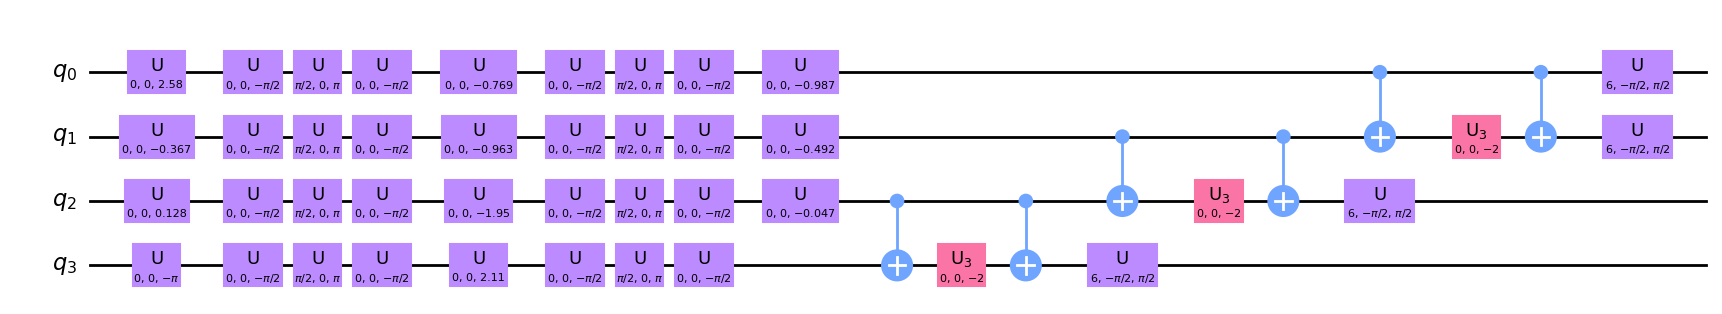

In [20]:
evol_gate = PauliEvolutionGate(H_op, time=dt*idx_ket, synthesis=SuzukiTrotter(order=1)) #MatrixExponential exact matrix exp, SuzukiTrotter(order=2) for order-2 Trotter evo op

qc_temp = QuantumCircuit(n_qubits)
qc_temp.compose(qc_state_prep, inplace=True)
qc_temp.append(evol_gate, qargs=qc_temp.data[0].qubits[0].register)
print(qc_temp.decompose().decompose().decompose().decompose().decompose().depth())
qc_temp.decompose().decompose().decompose().decompose().decompose().draw('mpl', fold=-1)

Then we can execute them

In [21]:
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator

service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("ibmq_qasm_simulator")
jobs = {} # store executed jobs
estimator = Estimator(backend=backend)

shots = 10000
observable = 'I'*(n_qubits) + 'Z'

S_real_results = estimator.run(S_real_circuits, observables = [observable]*len(S_real_circuits), shots=shots).result()
S_imag_results = estimator.run(S_imag_circuits, observables = [observable]*len(S_imag_circuits), shots=shots).result()


Finally, we can process the results and calculate all matrix elements

In [22]:
S_circ = np.zeros((krylov_dim, krylov_dim), dtype=complex)
count = 0
for idx_ket in range(krylov_dim):
    for idx_bra in range(idx_ket + 1):

        # Get quasi-distributions from experiment
        expval_real = S_real_results.values[count]
        expval_imag = S_imag_results.values[count]

        # Get expectation values
        expval = expval_real + 1j*expval_imag

        # Fill-in matrix elements
        S_circ[idx_bra, idx_ket] = expval
        S_circ[idx_ket, idx_bra] = expval.conjugate()

        count+=1

In [23]:
from sympy import Matrix
print('S matrix estimated from the circuit results')
display(Matrix(S_circ))
print("")
print("S matrix estimated numerically")
display(Matrix(S))

S matrix estimated from the circuit results


Matrix([
[     1.0 + 0.005*I,  0.8442 + 0.3658*I, 0.4976 + 0.5418*I, 0.1288 + 0.5116*I, -0.0672 + 0.3548*I, -0.1382 + 0.1234*I],
[ 0.8442 - 0.3658*I,     1.0 + 0.0114*I, 0.8604 + 0.3672*I, 0.5186 + 0.5772*I,  0.1432 + 0.5362*I, -0.0738 + 0.3382*I],
[ 0.4976 - 0.5418*I,  0.8604 - 0.3672*I,    1.0 - 0.0144*I,  0.862 + 0.3712*I,  0.5024 + 0.5584*I,   0.122 + 0.5356*I],
[ 0.1288 - 0.5116*I,  0.5186 - 0.5772*I,  0.862 - 0.3712*I,    1.0 + 0.0062*I,  0.8458 + 0.3762*I,   0.4774 + 0.558*I],
[-0.0672 - 0.3548*I,  0.1432 - 0.5362*I, 0.5024 - 0.5584*I, 0.8458 - 0.3762*I,     1.0 + 0.0096*I,  0.8506 + 0.3566*I],
[-0.1382 - 0.1234*I, -0.0738 - 0.3382*I,  0.122 - 0.5356*I,  0.4774 - 0.558*I,  0.8506 - 0.3566*I,     1.0 + 0.0194*I]])


S matrix estimated numerically


Matrix([
[                                      1.0,  0.848155244844915 + 0.359095465115828*I,  0.481745247202563 + 0.550389104477963*I, 0.0934656366164513 + 0.519308620060621*I, -0.164060863665587 + 0.332281539647771*I, -0.247793657103812 + 0.0939809302786221*I],
[  0.848155244844915 - 0.359095465115828*I,                                      1.0,  0.848155244844915 + 0.359095465115828*I,  0.481745247202562 + 0.550389104477963*I, 0.0934656366164514 + 0.519308620060621*I,  -0.164060863665587 + 0.332281539647771*I],
[  0.481745247202563 - 0.550389104477963*I,  0.848155244844915 - 0.359095465115828*I,                                      1.0,  0.848155244844915 + 0.359095465115828*I,  0.481745247202563 + 0.550389104477963*I,  0.0934656366164514 + 0.519308620060621*I],
[ 0.0934656366164513 - 0.519308620060621*I,  0.481745247202562 - 0.550389104477963*I,  0.848155244844915 - 0.359095465115828*I,                                      1.0,  0.848155244844915 + 0.359095465115828*I,   0.4817452

### Calculate $\tilde{H}$ from Hadamard test
The matrix elemetns of the Hamiltonian projected in the Krylov subspace $\tilde{H}$ can be calculated in a similar way. We need to calculate

$$\tilde{H}_{mn} = \langle \psi_0 \vert  e^{i \hat{H} t_m} H   e^{-i \hat{H} t_n} \vert \psi_0 \rangle$$

where we'll use a Pauli decomposition of the Hamiltonian $H=\sum p_i P_i$

Circuit to measure ZZII term of the Hamiltonian


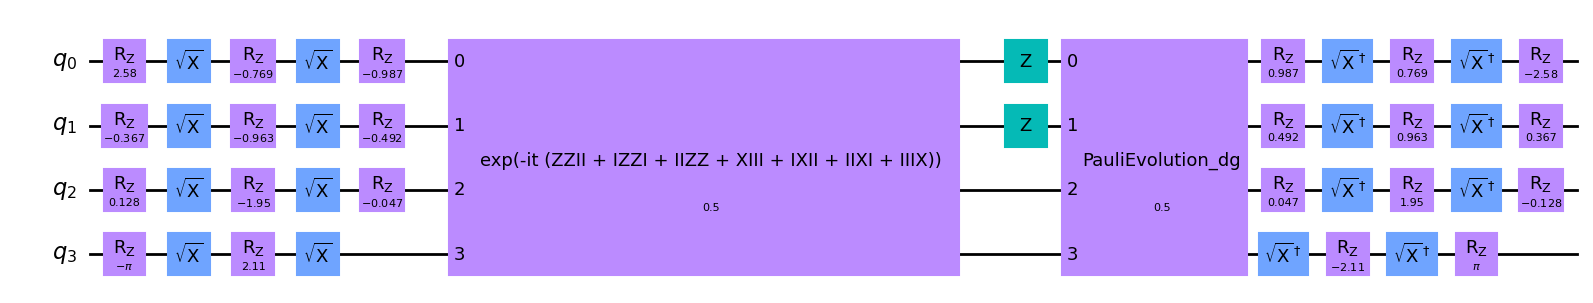


Circuit to measure IZZI term of the Hamiltonian


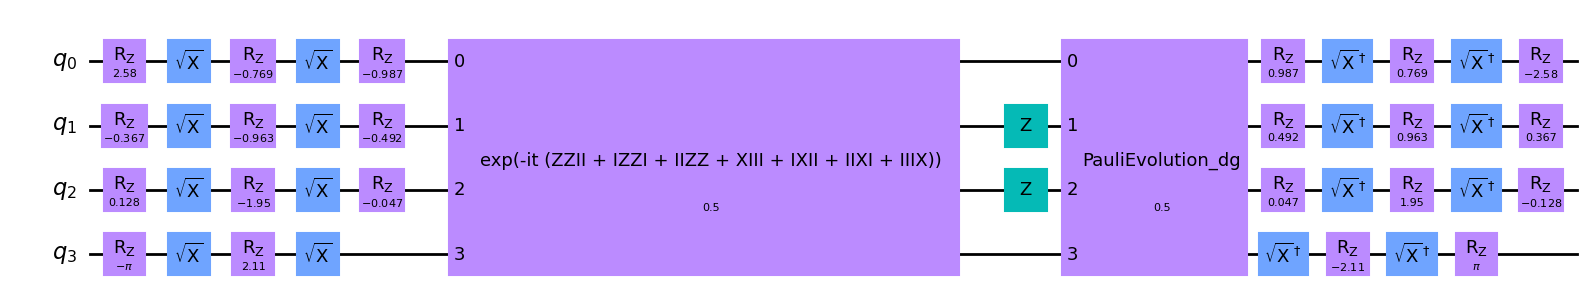


Circuit to measure IIZZ term of the Hamiltonian


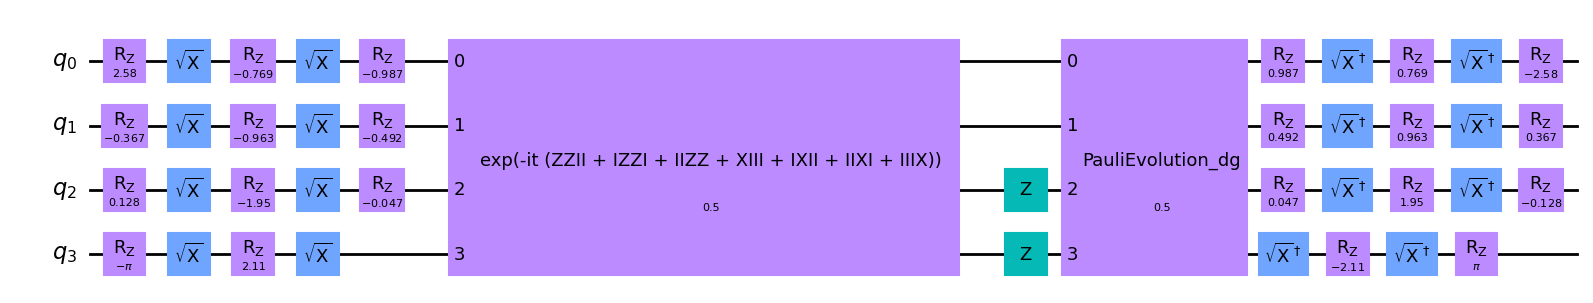


Circuit to measure XIII term of the Hamiltonian


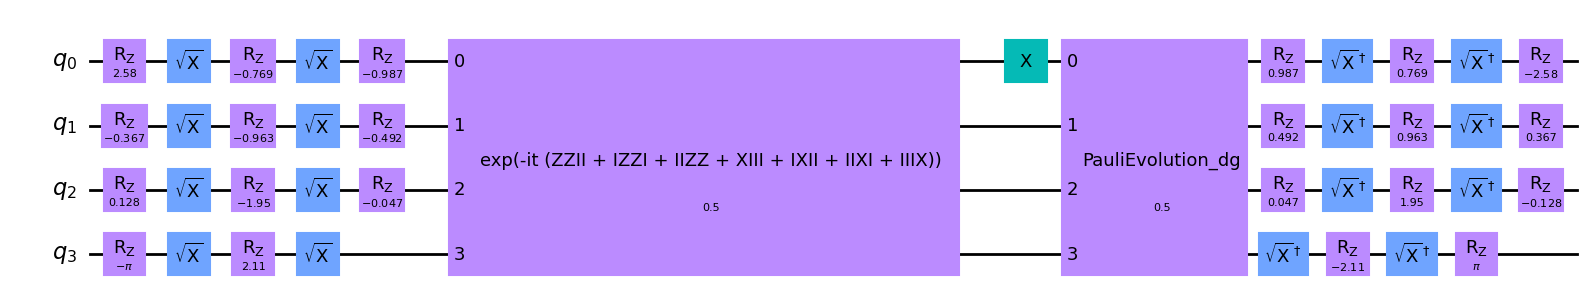


Circuit to measure IXII term of the Hamiltonian


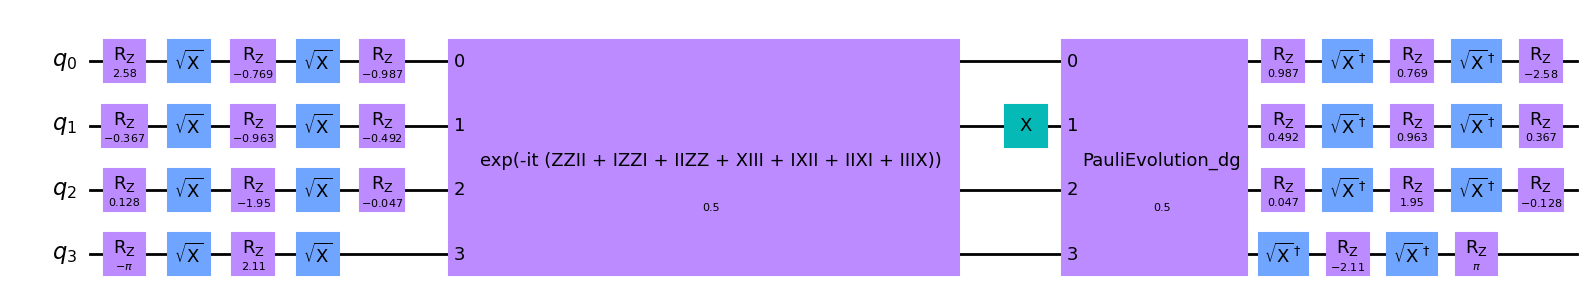


Circuit to measure IIXI term of the Hamiltonian


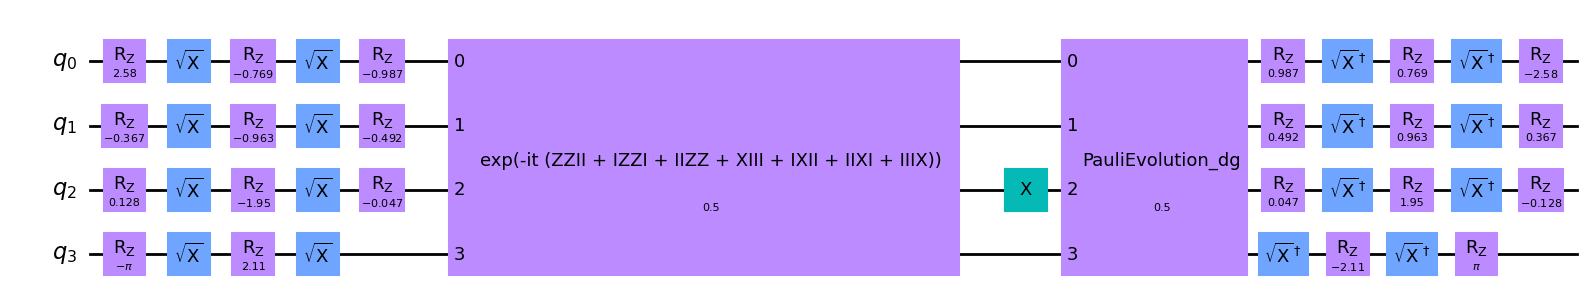


Circuit to measure IIIX term of the Hamiltonian


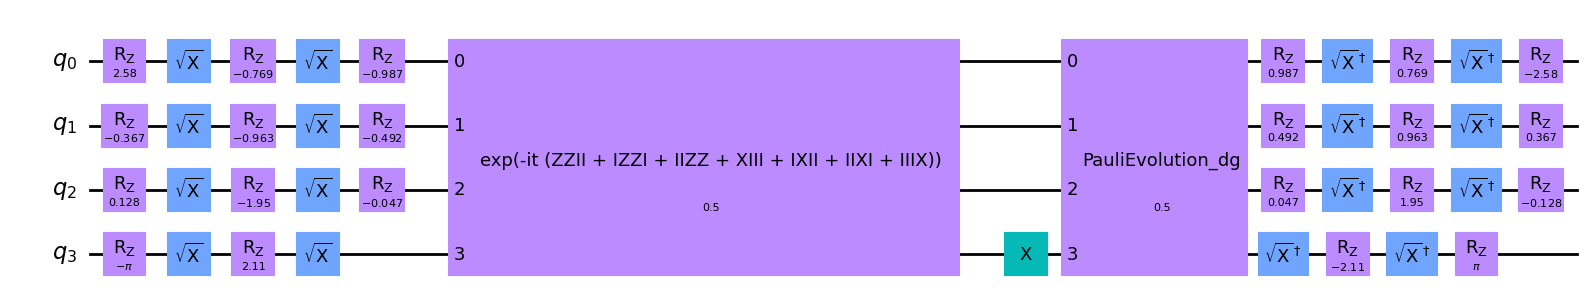

In [24]:
for pauli, coeff in zip(H_op.paulis, H_op.coeffs):
            
    # Put pieces together
    qc_temp = QuantumCircuit(n_qubits)
    qc_temp.compose(qc_state_prep, inplace=True)
    qc_temp.append(evol_gate, qargs=qc_temp.data[0].qubits[0].register)
    # qc_temp.compose(qc_op, inplace=True)
    for i, op in enumerate(pauli.to_label()):
        if op == 'X':
            qc_temp.x(i)
        if op == 'Y':
            qc_temp.y(i)
        if op == 'Z':
            qc_temp.z(i)
    qc_temp.append(evol_gate_d, qargs=qc_temp.data[0].qubits[0].register)
    # qc_temp.compose(qc_op_d, inplace=True)
    qc_temp.compose(qc_state_prep_d, inplace=True)

    print(f"Circuit to measure {pauli} term of the Hamiltonian")
    display(qc_temp.draw('mpl'))
    print('')

Similarly to $\tilde{S}$, let's build all the circuits to calculate $\tilde{H}$ first

In [25]:
H_real_circuits, H_imag_circuits = [], []
for pauli, coeff in zip(H_op.paulis, H_op.coeffs):
    print('measure H term', coeff, pauli.to_label())
    for idx_ket in range(krylov_dim):
        for idx_bra in range(idx_ket + 1):
        
            ## Create the time-evo op circuit
            evol_gate = PauliEvolutionGate(H_op, time=dt*idx_ket, synthesis=SuzukiTrotter(order=2)) #MatrixExponential exact matrix exp, SuzukiTrotter(order=2) for order-2 Trotter evo op

            ## Create the time-evo op dagger circuit
            evol_gate_d = PauliEvolutionGate(H_op, time=dt*idx_bra, synthesis=SuzukiTrotter(order=2))
            evol_gate_d = evol_gate_d.inverse()

            # Put pieces together
            qc_temp = QuantumCircuit(n_qubits)
            qc_temp.compose(qc_state_prep, inplace=True)
            qc_temp.append(evol_gate, qargs=qc_temp.data[0].qubits[0].register)
            for i, op in enumerate(pauli.to_label()):
                if op == 'X':
                    qc_temp.x(i)
                if op == 'Y':
                    qc_temp.y(i)
                if op == 'Z':
                    qc_temp.z(i)
            qc_temp.append(evol_gate_d, qargs=qc_temp.data[0].qubits[0].register)
            qc_temp.compose(qc_state_prep_d, inplace=True)

            # Create controlled version of the circuit
            controlled_U = qc_temp.to_gate().control(1)

            # Create hadamard test circuit for real part
            qr = QuantumRegister(n_qubits+1)
            cr = ClassicalRegister(1)
            qc_real = QuantumCircuit(qr, cr)
            qc_real.h(0)
            qc_real.append(controlled_U, list(range(n_qubits+1)))
            qc_real.h(0)
            qc_real.measure(qr[0], cr[0])

            H_real_circuits.append(qc_real.decompose().decompose())

            # Create hadamard test circuit for imaginary part
            qr = QuantumRegister(n_qubits+1)
            cr = ClassicalRegister(1)
            qc_imag = QuantumCircuit(qr, cr)
            qc_imag.h(0)
            qc_imag.sdg(0)
            qc_imag.append(controlled_U, list(range(n_qubits+1)))
            qc_imag.h(0)
            # qc_imag.measure(qr[0], cr[0])

            H_imag_circuits.append(qc_imag.decompose().decompose())


measure H term (-1+0j) ZZII
measure H term (-1+0j) IZZI
measure H term (-1+0j) IIZZ
measure H term (3+0j) XIII
measure H term (3+0j) IXII
measure H term (3+0j) IIXI
measure H term (3+0j) IIIX


Execute them

In [26]:
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator

service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("ibmq_qasm_simulator")

estimator = Estimator(backend=backend)
observable = 'I'*(n_qubits) + 'Z'
shots = 10000

H_real_results = estimator.run(H_real_circuits, observables=[observable]*len(H_real_circuits), shots=shots).result()
H_imag_results = estimator.run(H_imag_circuits, observables=[observable]*len(H_imag_circuits), shots=shots).result()


and process them

In [27]:
H_eff_circ = np.zeros((krylov_dim, krylov_dim), dtype=complex)
count = 0
for pauli, coeff in zip(H_op.paulis, H_op.coeffs):
    print('measure H term', coeff, pauli.to_label())
    for idx_ket in range(krylov_dim):
        for idx_bra in range(idx_ket + 1):

            # Get quasi-distributions from experiment
            expval_real = H_real_results.values[count]
            expval_imag = H_imag_results.values[count]

            # # Get expectation values
            expval = expval_real + 1j*expval_imag

            # Fill-in matrix elements
            H_eff_circ[idx_bra, idx_ket] += coeff*expval
            if idx_bra != idx_ket: # don't duplicate terms on diagonal
                H_eff_circ[idx_ket, idx_bra] += (coeff*expval).conjugate()



            count+=1

measure H term (-1+0j) ZZII
measure H term (-1+0j) IZZI
measure H term (-1+0j) IIZZ
measure H term (3+0j) XIII
measure H term (3+0j) IXII
measure H term (3+0j) IIXI
measure H term (3+0j) IIIX


In [28]:
from sympy import Matrix
print('H_eff matrix estimated from the circuit results')
display(Matrix(H_eff_circ))
print("")
print("H_eff matrix estimated numerically")
display(Matrix(H_eff))

H_eff matrix estimated from the circuit results


Matrix([
[  -3.8784 - 0.02*I, -2.9526 - 2.7926*I,  -0.719 - 4.1108*I,  1.3802 - 3.3454*I,  2.2844 - 1.6696*I,   2.174 - 0.1598*I],
[-2.9526 + 2.7926*I, -3.8016 - 0.0626*I, -2.8354 - 2.7372*I,    -0.66 - 3.788*I,  1.4212 - 2.8012*I,  2.0946 - 1.1544*I],
[ -0.719 + 4.1108*I, -2.8354 + 2.7372*I,  -3.8728 + 0.034*I,  -2.781 - 2.6038*I,   -0.547 - 3.325*I,  1.3104 - 2.4414*I],
[ 1.3802 + 3.3454*I,    -0.66 + 3.788*I,  -2.781 + 2.6038*I,  -3.6004 + 0.062*I, -2.5154 - 2.4704*I, -0.5376 - 3.4652*I],
[ 2.2844 + 1.6696*I,  1.4212 + 2.8012*I,   -0.547 + 3.325*I, -2.5154 + 2.4704*I, -3.2718 - 0.0946*I,  -2.2152 - 2.632*I],
[  2.174 + 0.1598*I,  2.0946 + 1.1544*I,  1.3104 + 2.4414*I, -0.5376 + 3.4652*I,  -2.2152 + 2.632*I, -2.9432 - 0.1406*I]])


H_eff matrix estimated numerically


Matrix([
[-3.91858990897195 - 2.22044604925031e-16*I,      -2.96164378427887 - 2.8734834802044*I,     -0.772499747266053 - 4.1053350937096*I,      1.26638899883635 - 3.39328585004785*I,      2.28659693349833 - 1.69550205861274*I, 2.35748052782969 - 0.0325127788885871*I],
[     -2.96164378427887 + 2.8734834802044*I, -3.91858990897195 + 1.11022302462516e-16*I,      -2.96164378427887 - 2.8734834802044*I,     -0.772499747266053 - 4.1053350937096*I,      1.26638899883635 - 3.39328585004785*I,   2.28659693349833 - 1.69550205861274*I],
[    -0.772499747266053 + 4.1053350937096*I,      -2.96164378427887 + 2.8734834802044*I, -3.91858990897195 - 2.22044604925031e-16*I,      -2.96164378427887 - 2.8734834802044*I,     -0.772499747266053 - 4.1053350937096*I,   1.26638899883635 - 3.39328585004785*I],
[     1.26638899883635 + 3.39328585004785*I,     -0.772499747266053 + 4.1053350937096*I,      -2.96164378427887 + 2.8734834802044*I, -3.91858990897195 - 1.11022302462516e-16*I,      -2.96164378427887 - 

### Estimate energy

In [29]:
gnd_en_circ_est_list = []
for d in range(1, krylov_dim+1):
    # Solve generalized eigenvalue problem
    gnd_en_circ_est = solve_regularized_gen_eig(H_eff_circ[:d, :d], S_circ[:d, :d], threshold=2e-2)
    gnd_en_circ_est_list.append(gnd_en_circ_est)
    print('The estimated ground state energy is: ', gnd_en_circ_est)

The estimated ground state energy is:  -3.8783999999999996
The estimated ground state energy is:  -6.132941160162141
The estimated ground state energy is:  -6.539054951975634
The estimated ground state energy is:  -7.680808416082359
The estimated ground state energy is:  -7.363464507619569
The estimated ground state energy is:  -8.927198130745175


Text(0.5, 1.0, 'Estimating Ground state energy with Quantum Krylov')

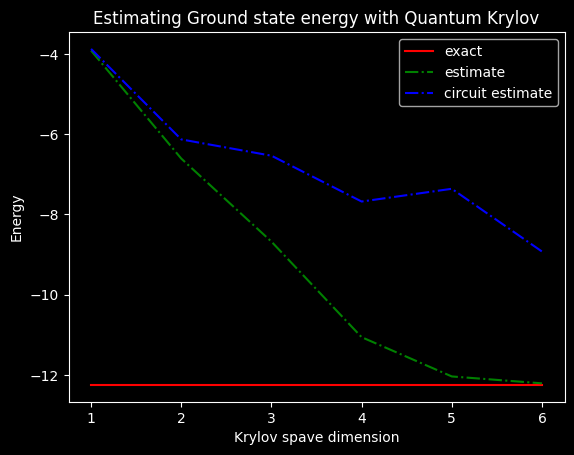

In [30]:
plt.plot(range(1, len(krylov_subspace)+1), [gnd_en]*(len(krylov_subspace)), color = 'red', label = 'exact')
plt.plot(range(1, len(krylov_subspace)+1), gnd_en_est_list, color = 'green', linestyle='-.' , label = 'estimate')
plt.plot(range(1, len(krylov_subspace)+1), gnd_en_circ_est_list, color = 'blue', linestyle='-.' , label = 'circuit estimate')
plt.xticks(range(1, len(krylov_subspace)+1), range(1, len(krylov_subspace)+1))
plt.legend()
plt.xlabel('Krylov spave dimension')
plt.ylabel('Energy')
plt.title('Estimating Ground state energy with Quantum Krylov')

### Effects of noise
Let's setup a custom noise model that we can pass to Qiskit Runtime to simulate on the cloud

In [31]:
from qiskit.providers.fake_provider import FakeBogota
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime import Options

def scale_backend_props(backend, l1=1, l2=1, lg=1):
    """scale t1 by 1/l1, t2 by 1/l2, and gate error by lg

    Args:
        backend (backend): _description_
        l1 (int, optional): Scales T1 * (1/l1). Defaults to 1.
        l2 (int, optional): Scales T2 * (1/l2). Defaults to 1.
        lg (int, optional): Scales gate_error * lg. Defaults to 1.

    Returns:
        backend.properties()
    """
    org_prop = backend.properties().to_dict()
    for gate_index in range(len(org_prop["gates"])):
        i = 0
        for param in org_prop["gates"][gate_index]["parameters"]:
            if param["name"] == "gate_error":
                # print(i)
                org_prop["gates"][gate_index]["parameters"][0]["value"] = (
                    lg * org_prop["gates"][gate_index]["parameters"][0]["value"]
                )
                i += 1
            else:
                i += 1
    for qubit_index in range(len(org_prop["qubits"])):
        i = 0
        for param in org_prop["qubits"][qubit_index]:
            # print(i, param['name'])
            if param["name"] == "T1":
                old_val = org_prop["qubits"][qubit_index][i]["value"]
                org_prop["qubits"][qubit_index][i]["value"] = (1 / l1) * old_val
                i += 1
            elif param["name"] == "T2":
                old_val = org_prop["qubits"][qubit_index][i]["value"]
                org_prop["qubits"][qubit_index][i]["value"] = (1 / l2) * old_val
                i += 1
            else:
                i += 1
    return backend.properties().from_dict(org_prop)

# Make a noise model
fake_backend = FakeBogota()
# noise_model = NoiseModel.from_backend(fake_backend)

new_props = scale_backend_props(fake_backend, l1=0.1, l2=0.1, lg=0.1)
noise_model = NoiseModel.from_backend_properties(
    new_props,
    gate_error=True,
    readout_error=True,
    thermal_relaxation=True,
)




# Set options to include the noise model
options = Options()
options.simulator = {
    "noise_model": noise_model,
    "basis_gates": fake_backend.configuration().basis_gates,
    "coupling_map": fake_backend.configuration().coupling_map,
    "seed_simulator": 42
}

We can then run the circuits for estimating $\tilde{H}$ and $\tilde{S}$ with the noisy simulator

In [32]:
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator

service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("ibmq_qasm_simulator")
# backend = service.backend("ibm_kyiv")

label_mit = 'unmitigated'
jobs[label_mit] = []

estimator = Estimator(backend=backend, options=options)
options.optimization_level = 3

shots = 10000
observable = 'I'*(n_qubits) + 'Z'

job = estimator.run(S_real_circuits, observables = [observable]*len(S_real_circuits), shots=shots)
jobs[label_mit].append(job)
print(job.job_id())
S_real_noisy_results = job.result()

job = estimator.run(S_imag_circuits, observables = [observable]*len(S_imag_circuits), shots=shots)
jobs[label_mit].append(job)
print(job.job_id())
S_imag_noisy_results = job.result()

job = estimator.run(H_real_circuits, observables = [observable]*len(H_real_circuits), shots=shots)
jobs[label_mit].append(job)
print(job.job_id())
H_real_noisy_results = job.result()

job = estimator.run(H_imag_circuits, observables = [observable]*len(H_imag_circuits), shots=shots)
jobs[label_mit].append(job)
print(job.job_id())
H_imag_noisy_results = job.result()

ckiuvq2een13a867eflg
ckiv0hrgl0ct1nudomk0
ckiv1cc1rec1pkov2fbg
ckiv62smjg3o147ck4t0


In [33]:
S_circ_noisy = np.zeros((krylov_dim, krylov_dim), dtype=complex)
count = 0
for idx_ket in range(krylov_dim):
    for idx_bra in range(idx_ket + 1):

        # Get quasi-distributions from experiment
        expval_real = S_real_noisy_results.values[count]
        expval_imag = S_imag_noisy_results.values[count]

        # Get expectation values
        expval = expval_real + 1j*expval_imag

        # Fill-in matrix elements
        S_circ_noisy[idx_bra, idx_ket] = expval
        S_circ_noisy[idx_ket, idx_bra] = expval.conjugate()

        count+=1


H_eff_circ_noisy = np.zeros((krylov_dim, krylov_dim), dtype=complex)
count = 0
for pauli, coeff in zip(H_op.paulis, H_op.coeffs):
    print('measure H term', coeff, pauli.to_label())
    for idx_ket in range(krylov_dim):
        for idx_bra in range(idx_ket + 1):

            # Get quasi-distributions from experiment
            expval_real = H_real_noisy_results.values[count]
            expval_imag = H_imag_noisy_results.values[count]

            # # Get expectation values
            expval = expval_real + 1j*expval_imag

            # Fill-in matrix elements
            H_eff_circ_noisy[idx_bra, idx_ket] += coeff*expval
            if idx_bra != idx_ket: # don't duplicate terms on diagonal
                H_eff_circ_noisy[idx_ket, idx_bra] += (coeff*expval).conjugate()


            count+=1

measure H term (-1+0j) ZZII
measure H term (-1+0j) IZZI
measure H term (-1+0j) IIZZ
measure H term (3+0j) XIII
measure H term (3+0j) IXII
measure H term (3+0j) IIXI
measure H term (3+0j) IIIX


In [34]:
gnd_en_noisy_circ_est_list = []
for d in range(1, krylov_dim+1):
    # Solve generalized eigenvalue problem
    gnd_en_circ_est = solve_regularized_gen_eig(H_eff_circ_noisy[:d, :d], S_circ_noisy[:d, :d], threshold=5e-2)
    gnd_en_noisy_circ_est_list.append(gnd_en_circ_est)
    print('The estimated ground state energy is: ', gnd_en_circ_est)

The estimated ground state energy is:  -3.3394370365797217
The estimated ground state energy is:  -3.8543386332148835
The estimated ground state energy is:  -5.74804175266128
The estimated ground state energy is:  -6.313714590841862
The estimated ground state energy is:  -5.922077655558441
The estimated ground state energy is:  -6.854826990692626


Text(0.5, 1.0, 'Estimating Ground state energy with Quantum Krylov')

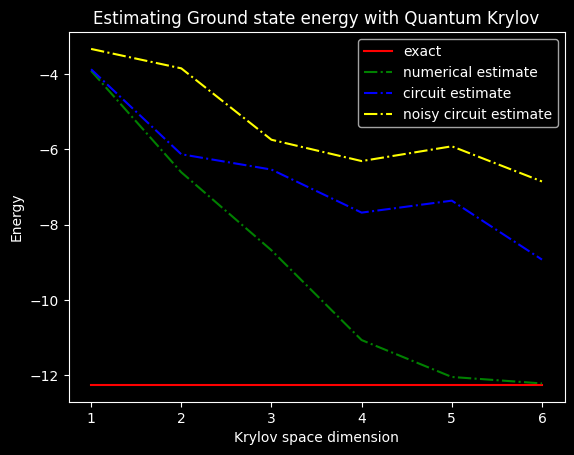

In [35]:
plt.plot(range(1, len(krylov_subspace)+1), [gnd_en]*(len(krylov_subspace)), color = 'red', label = 'exact')
plt.plot(range(1, len(krylov_subspace)+1), gnd_en_est_list, color = 'green', linestyle='-.' , label = 'numerical estimate')
plt.plot(range(1, len(krylov_subspace)+1), gnd_en_circ_est_list, color = 'blue', linestyle='-.' , label = 'circuit estimate')
plt.plot(range(1, len(krylov_subspace)+1), gnd_en_noisy_circ_est_list, color = 'yellow', linestyle='-.' , label = 'noisy circuit estimate')
plt.xticks(range(1, len(krylov_subspace)+1), range(1, len(krylov_subspace)+1))
plt.legend()
plt.xlabel('Krylov space dimension')
plt.ylabel('Energy')
plt.title('Estimating Ground state energy with Quantum Krylov')

### Hands-on part: Try adding error mitigation schemes
A simple way to do this in Qiskit IBM Runtime is to specify the Resilience options. For example `resilience_level = 1` add readout error mitigation to your jobs.